# 1. Creating the Dataset

In [ ]:
import json
import sympy
import numpy as np
import random
import logging
import re

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Constants
PI = sympy.pi
E = sympy.E
PHI = (1 + sympy.sqrt(5))/2

def random_constants():
    constants = [PI, E, PHI, sympy.sqrt(2), -PI, -E, -PHI, -sympy.sqrt(2)]
    return random.choice(constants)

def random_coefficient():
    if random.random() < 0.5:
        return random.randint(-10, 10)
    else:
        return random.uniform(-5, 5)

def generate_variables(n):
    symbol_list = sympy.symbols(f'x0:{n}')
    return symbol_list

def generate_random_function_with_relevance(variables, num_relevant_vars, complexity_range=(3, 6)):
    relevant_vars = random.sample(variables, num_relevant_vars)
    num_ops = random.randint(*complexity_range)
    function = random.choice(relevant_vars)
    for _ in range(num_ops):
        op = random.choice([sympy.Add, sympy.Mul, sympy.sin, sympy.cos, sympy.exp, sympy.Pow, sympy.tanh])
        if op in [sympy.Add, sympy.Mul]:
            function = op(function, random.choice(relevant_vars + [random_constants(), random_coefficient()]))
        elif op == sympy.Pow:
            function = op(function, random.choice([2, 3, 4]))
        else:
            function = op(function)
    return function

def generate_physics_function(variables):
    functions = [
        random_coefficient() * variables[0]**2 + random_coefficient() * variables[1],
        sympy.sin(variables[0]) + random_coefficient() * sympy.cos(variables[1]),
        random_coefficient() * variables[0]**3 + random_coefficient() * variables[1]**2 + random_coefficient() * 3*variables[0]*variables[1],  # Polynomial function
        random_coefficient() * (sympy.Mul(variables[0], 9.8)),
        random_coefficient() * sympy.tanh(variables[0] + random_coefficient()) 
    ]
    return random.choice(functions)

def nguyen_benchmark_equations_dynamic(n=2, num_functions=100):
    variables = generate_variables(n)
    functions = []
    for _ in range(num_functions):
        num_relevant_vars = random.randint(1, n)
        if random.random() > 0.5:
            functions.append(generate_physics_function(variables))
        else:
            functions.append(generate_random_function_with_relevance(variables, num_relevant_vars))
    return functions

def evaluate_nguyen_benchmark_equations_with_relevant_variables(functions, num_samples=100, range_vals=(-1, 1)):
    dataset = []
    for func in functions:
        data = {"x": {}, "y": []}
        skeleton = create_skeleton(func)
        num_vars = max([int(str(var)[1:]) for var in func.free_symbols]) + 1
        all_variables = generate_variables(num_vars)
        
        for var in all_variables:
            data["x"][str(var)] = []

        for _ in range(num_samples):
            inputs = {str(var): np.random.uniform(*range_vals) for var in all_variables}
            relevant_inputs = {str(var): inputs[str(var)] for var in func.free_symbols}
            try:
                result = func.evalf(subs=relevant_inputs)
                if result.is_real:
                    output = float(result)
                else:
                    logger.warning(f"Complex result for {str(func)}: {result}. Skipping this data point.")
                    continue 
                for var in all_variables:
                    data["x"][str(var)].append(inputs[str(var)])
                data["y"].append(output)
            except (ValueError, ZeroDivisionError, OverflowError) as e:
                logger.warning(f"Invalid expression for {str(func)}: {e}")
                continue

        dataset.append({"function": str(func), "skeleton": skeleton, "data": data})
    
    return dataset

def save_to_json_line_by_line(data, filename):
    with open(filename, "w") as f:
        for data_point in data:
            json.dump(data_point, f)
            f.write("\n")

def create_skeleton(input_function):
    input_function_str = str(input_function)
    scientific_constants = [sympy.pi, sympy.E, (1 + sympy.sqrt(5))/2]
    for constant in scientific_constants:
        input_function_str = input_function_str.replace(str(constant), 'C')
    skeleton = re.sub(r"sqrt\(([+-]?\d*\.?\d+)\)", "C", input_function_str)
    skeleton = re.sub(r"exp\(([+-]?\d*\.?\d+)\)", "C", skeleton)
    skeleton = re.sub(
        r"([+-]?\d*\.?\d+)(?=[a-zA-Z(])",
        "C",
        skeleton
    )
    skeleton = re.sub(
        r"(?<![\w^*])([+-]?\d*\.?\d+)(?![*]{2})",
        "C",
        skeleton
    )
    skeleton = re.sub(r"-\s*C", "+ C", skeleton)
    skeleton = re.sub(r"C\s*/\s*C", "C", skeleton)
    skeleton = re.sub(r"C\s*\+\s*C", "C", skeleton)
    skeleton = re.sub(r"\(C\)", "C", skeleton)
    skeleton = re.sub(r"-\s*C", "C", skeleton)
    skeleton = re.sub(r"^\-", "C*", skeleton)
    return skeleton

seed = 123
random.seed(seed)
np.random.seed(seed)

n_variables = 5 
num_functions = 100 

nguyen_functions = nguyen_benchmark_equations_dynamic(n_variables, num_functions)


nguyen_benchmark_equations_evaluated = evaluate_nguyen_benchmark_equations_with_relevant_variables(nguyen_functions, num_samples=100, range_vals=(-1, 1))

file_path_combined = f"Data/combined_dataset_{n_variables}_variables_dynamic_seed{seed}.json"
save_to_json_line_by_line(nguyen_benchmark_equations_evaluated, file_path_combined)

print(f"Combined and shuffled dataset saved to {file_path_combined}")

Combined and shuffled dataset saved to Data/combined_dataset_5_variables_dynamic_seed20777980.json


# 2. Preprocess and Tokenize Data

In [ ]:
import json
import numpy as np
import random
import re
import gensim
from gensim.models import Word2Vec
from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
from torch.nn import functional as F
from dataclasses import dataclass
import pdb

seed = 123
random.seed(seed)
np.random.seed(seed)

PAD_TOKEN = "<PAD>"
NOISE_LEVEL = 0.1
EMBEDDING_DIM = 100
EPOCHS = 50
PATIENCE = 3
MIN_DELTA = 0.0001

@dataclass
class tNetConfig:
    num_vars: int
    embedding_size: int

class tNet(nn.Module):
    def __init__(self, config: tNetConfig):
        super(tNet, self).__init__()

        self.config = config
        self.num_vars = config.num_vars
        self.n_embd = config.embedding_size

        self.activation_func = F.relu

        self.conv1 = nn.Conv1d(self.num_vars, self.n_embd, 1)
        self.conv2 = nn.Conv1d(self.n_embd, 2*self.n_embd, 1)
        self.conv3 = nn.Conv1d(2*self.n_embd, 4*self.n_embd, 1)

        self.fc1 = nn.Linear(4*self.n_embd, 2*self.n_embd)
        self.fc2 = nn.Linear(2*self.n_embd, self.n_embd)

        self.input_batch_norm = nn.GroupNorm(1, self.num_vars)
        
        self.bn1 = nn.GroupNorm(1, self.n_embd)
        self.bn2 = nn.GroupNorm(1, 2*self.n_embd)
        self.bn3 = nn.GroupNorm(1, 4*self.n_embd)
        self.bn4 = nn.GroupNorm(1, 2*self.n_embd)
        self.bn5 = nn.GroupNorm(1, self.n_embd)

    def forward(self, x):
        x = self.input_batch_norm(x)
        x = self.activation_func(self.bn1(self.conv1(x)))
        x = self.activation_func(self.bn2(self.conv2(x)))
        x = self.activation_func(self.bn3(self.conv3(x)))
        x, _ = torch.max(x, dim=2)
        assert x.size(1) == 4 * self.n_embd
        x = self.activation_func(self.bn4(self.fc1(x)))
        x = self.activation_func(self.bn5(self.fc2(x)))
        return x

def tokenize_skeleton(skeleton_str):
    skeleton_str = skeleton_str.replace("**", "^")
    pattern = r'[a-zA-Z_][a-zA-Z0-9_]*|[+\-*/^(),.]|C|sin|cos|log|exp|sqrt'
    tokens = re.findall(pattern, skeleton_str)
    return tokens

def train_word2vec_embeddings(dataset, embedding_dim=EMBEDDING_DIM, epochs=EPOCHS, patience_num_epochs=PATIENCE):
    sentences = []
    for entry in dataset:
        skeleton_str = entry["skeleton"]
        tokens = tokenize_skeleton(skeleton_str)
        sentences.append(tokens)
    
    model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4, epochs=1)

    best_loss = np.inf
    num_epochs_without_improvement = 0
    early_stopping = False

    performance_metrics_DICT = {
        "epoch_list": [],
        "train_loss_list": [],
    }

    for epoch in range(epochs-1):
        model.train(sentences, total_examples=model.corpus_count, epochs=1)
        current_loss = model.get_latest_training_loss()
        performance_metrics_DICT['epoch_list'].append(epoch+1)
        performance_metrics_DICT['train_loss_list'].append(current_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {current_loss}")
        if current_loss < best_loss:
            best_loss = current_loss
            model.save("Data/embeddings_model.model")
            num_epochs_without_improvement = 0
            save_JSON(performance_metrics_DICT,'Data/embeddings_performance_metrics_DICT.json')
        else:
            num_epochs_without_improvement += 1

        if num_epochs_without_improvement >= patience_num_epochs:
            print(f'Early stopping occurred at epoch {epoch + 1}')
            early_stopping = True
            break
        
    if early_stopping == False:
        model.save("Data/embeddings_model.model")
        save_JSON(performance_metrics_DICT,'Data/embeddings_performance_metrics_DICT.json')
    return model, performance_metrics_DICT

def build_vocab_and_embeddings(dataset, model=None):
    token_set = set()
    for entry in dataset:
        skeleton_str = entry["skeleton"]
        tokens = tokenize_skeleton(skeleton_str)
        token_set.update(tokens)
    vocab_embeddings = {}
    if model:
        for token in token_set:
            if token in model.wv:
                embedding = model.wv[token]
                embedding = normalize([embedding])[0]
                vocab_embeddings[token] = embedding
            else:
                vocab_embeddings[token] = np.random.uniform(-0.1, 0.1, size=EMBEDDING_DIM)
    else:
        for token in token_set:
            vocab_embeddings[token] = np.random.uniform(-0.1, 0.1, size=EMBEDDING_DIM)
    vocab_embeddings[PAD_TOKEN] = np.zeros(EMBEDDING_DIM)
    return vocab_embeddings

def standardize_data(data):
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)    
    data_standardized = (data - data_mean)/data_std
    return data_standardized

def tokenize_dataset_with_embeddings(dataset, vocab_embeddings):
    tokenized_data = []
        
    max_num_features  = max(len(entry['data']['x']) for entry in dataset)
    
    for entry in dataset:
        skeleton_str = entry["skeleton"]
        tokenized_skeleton = [vocab_embeddings[token] for token in tokenize_skeleton(skeleton_str)]
        
        data = entry["data"]
        x_DICT = data['x'] 
                    
        num_data_points = len(x_DICT[list(x_DICT.keys())[0]])
        num_features = len(list(x_DICT.keys()))
                
        x_with_values_MAT = np.array(list(x_DICT.values())).T
        x_with_values_standardized_MAT = standardize_data(x_with_values_MAT)
        nan_MAT = np.full((num_data_points, max_num_features-num_features), np.nan)
        x_standardized_MAT = np.concatenate((x_with_values_standardized_MAT, nan_MAT), axis=1)        
        
        y = np.array(data['y'])
        y_standardized = standardize_data(y)
        
        mask = np.array([1]*num_features + [0]*(max_num_features-num_features))        
        
        data_DICT = {'x': x_standardized_MAT, 'y': y_standardized, 'mask': mask}
        
        tokenized_data.append({
            "tokens": tokenized_skeleton,
            "data": data_DICT,
            "skeleton": skeleton_str
        })
    
    return tokenized_data

def pad_sequences(tokenized_data, max_length, pad_embedding, pad_token=PAD_TOKEN):
    """Pad tokenized sequences to a fixed length.""" 
    for dp in tokenized_data:
        token_length = len(dp["tokens"])
        if token_length < max_length:
            dp["tokens"] = dp["tokens"] + [pad_embedding]*(max_length - token_length)
        elif token_length > max_length:
            dp["tokens"] = dp["tokens"][:max_length]
    return tokenized_data

def load_dataset(file_path):
    """Load the dataset from a JSON file."""
    with open(file_path, 'r') as file:
        dataset = [json.loads(line) for line in file]
    return dataset

def add_TNet_embeddings(preprocessed_data):
    tokenized_formulas = torch.tensor([datapoint['tokens'] for datapoint in preprocessed_data]).float()
    datasets = torch.tensor([np.concatenate((datapoint['data']['x'], datapoint['data']['y'].reshape(len(datapoint['data']['y']),1)), axis=1) for datapoint in preprocessed_data])
    datasets = torch.nan_to_num(datasets,nan=0.0).float()

    batch_size, seq_len, embedding_dim = tokenized_formulas.shape
    batch_size, num_points, num_features = datasets.shape

    config_formula = tNetConfig(num_vars=seq_len, embedding_size=128) 
    config_data = tNetConfig(num_vars=num_points, embedding_size=128)

    TNet_model_formula = tNet(config_formula) 
    TNet_model_data = tNet(config_data)

    formula_embeddings = TNet_model_formula(tokenized_formulas)  # Shape: [num_formulas, embedding_size]
    dataset_embeddings = TNet_model_data(datasets)  # Shape: [batch_size, embedding_size]

    formula_embeddings = formula_embeddings.detach().cpu().numpy()
    dataset_embeddings = dataset_embeddings.detach().cpu().numpy()

    # Add embeddings to each datapoint in preprocessed_data
    for i, datapoint in enumerate(preprocessed_data):
        datapoint['formula_embedding'] = formula_embeddings[i]
        datapoint['dataset_embedding'] = dataset_embeddings[i]
    return preprocessed_data

def preprocess_and_tokenize_dataset(file_path, model=None, noise_type="gaussian", noise_level=NOISE_LEVEL, max_length='max_length'):
    # Step 1: Load dataset
    dataset = load_dataset(file_path)

    # Step 2: Train Word2Vec model if not provided
    if model is None:
        model, performance_metrics_DICT = train_word2vec_embeddings(dataset)

    # Step 3: Build vocabulary with embeddings
    vocab_embeddings = build_vocab_and_embeddings(dataset, model)

    # Step 4: Tokenize dataset and convert tokens to embeddings
    tokenized_data = tokenize_dataset_with_embeddings(dataset, vocab_embeddings)

    if max_length == 'max_length':
        MAX_LENGTH = max(len(dp["tokens"]) for dp in tokenized_data)
    else:
        MAX_LENGTH = max_length
    
    # Step 7: Pad sequences to a fixed length
    padded_data = pad_sequences(tokenized_data,MAX_LENGTH,vocab_embeddings['<PAD>'])
    
    preprocessed_data = add_TNet_embeddings(padded_data)
    
    return padded_data, vocab_embeddings, model, performance_metrics_DICT

# Save preprocessed data
def save_preprocessed_data(data, output_path):
    """Save the preprocessed data to a file with JSON serialization."""
    def convert_to_serializable(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()  # Convert ndarray to list
        if isinstance(obj, dict):
            return {key: convert_to_serializable(value) for key, value in obj.items()}
        if isinstance(obj, list):
            return [convert_to_serializable(item) for item in obj]
        return obj  # Return the object as-is if it's already serializable

    with open(output_path, 'w') as file:
        for dp in data:
            json.dump(convert_to_serializable(dp), file)
            file.write("\n")

def save_JSON(data, filename):
    """Save data to a JSON file with support for NumPy arrays."""
    def convert_to_serializable(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()  # Convert ndarray to list
        if isinstance(obj, dict):
            return {key: convert_to_serializable(value) for key, value in obj.items()}
        return obj  # Return the object as-is if it's already serializable

    with open(filename, 'w') as f:
        json.dump(convert_to_serializable(data), f)
        
def load_JSON(filename):
    """Load a JSON file."""
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

# Main script execution
file_path = "Data/combined_dataset_5_variables_dynamic_seed940.json"

# Process the data and train Word2Vec embeddings
preprocessed_data, vocab_embeddings, model, performance_metrics_DICT = preprocess_and_tokenize_dataset(file_path)

# Save the preprocessed data, vocab embeddings, and trained Word2Vec model
save_preprocessed_data(preprocessed_data, "Data/preprocessed_data_with_embeddings.json")
save_JSON(vocab_embeddings, "Data/vocab_embeddings.json")

print("Preprocessing complete with embeddings. Data saved.")

Epoch 1/50, Train Loss: 0.0
Epoch 2/50, Train Loss: 0.0
Epoch 3/50, Train Loss: 0.0
Epoch 4/50, Train Loss: 0.0
Early stopping occurred at epoch 4
Preprocessing complete with embeddings. Data saved.


In [ ]:
performance_metrics_DICT = load_JSON('Data/embeddings_performance_metrics_DICT.json')
model = Word2Vec.load("Data/embeddings_model.model")

print("Embeddings Performance Metrics:")
print(performance_metrics_DICT)

Embeddings Performance Metrics:
{'epoch_list': [1], 'train_loss_list': [0.0]}


# 3. Diffusion Model Training 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader, random_split
import random
import numpy as np
import json
import math
from torch.nn import functional as F
from dataclasses import dataclass
import pdb

seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

def determine_max_seq_len(data, max_length='max_length'):
    if max_length == 'max_length':
        MAX_LENGTH = max(len(dp["tokens"]) for dp in data)
    else:
        MAX_LENGTH = max_length
    return MAX_LENGTH

def setup_device():
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    return model

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()
    device = setup_device()
    model.to(device)
    return model, device

def load_dataset(filepath):
    with open(filepath, 'r') as file:
        dataset = [json.loads(line) for line in file]
    return dataset

def save_JSON(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f)
    return

def load_JSON(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

@dataclass
class tNetConfig:
    num_vars: int
    embedding_size: int

class tNet(nn.Module):
    def __init__(self, config: tNetConfig):
        super(tNet, self).__init__()

        self.config = config
        self.num_vars = config.num_vars
        self.n_embd = config.embedding_size

        self.activation_func = F.relu

        self.conv1 = nn.Conv1d(self.num_vars, self.n_embd, 1)
        self.conv2 = nn.Conv1d(self.n_embd, 2*self.n_embd, 1)
        self.conv3 = nn.Conv1d(2*self.n_embd, 4*self.n_embd, 1)

        self.fc1 = nn.Linear(4*self.n_embd, 2*self.n_embd)
        self.fc2 = nn.Linear(2*self.n_embd, self.n_embd)

        self.input_batch_norm = nn.GroupNorm(1, self.num_vars)
        
        self.bn1 = nn.GroupNorm(1, self.n_embd)
        self.bn2 = nn.GroupNorm(1, 2*self.n_embd)
        self.bn3 = nn.GroupNorm(1, 4*self.n_embd)
        self.bn4 = nn.GroupNorm(1, 2*self.n_embd)
        self.bn5 = nn.GroupNorm(1, self.n_embd)

    def forward(self, x):
        x = self.input_batch_norm(x)
        x = self.activation_func(self.bn1(self.conv1(x)))
        x = self.activation_func(self.bn2(self.conv2(x)))
        x = self.activation_func(self.bn3(self.conv3(x)))

        x, _ = torch.max(x, dim=2) 
        assert x.size(1) == 4*self.n_embd

        x = self.activation_func(self.bn4(self.fc1(x)))
        x = self.activation_func(self.bn5(self.fc2(x)))
        return x

class CosineNoiseSchedule:
    def __init__(self, timesteps=1000, epsilon=1e-6, device=None):
        self.timesteps = timesteps
        self.epsilon = epsilon
        self.device = device
        self.alphas = torch.cos(torch.linspace(0, math.pi / 2, timesteps, device=device)) ** 2
        self.betas = 1.0 - self.alphas
        self.alpha_bar = torch.maximum(torch.cumprod(self.alphas, dim=0), torch.tensor(self.epsilon, device=self.alphas.device))

    def get_alpha(self, t):
        return self.alphas[t]

    def get_beta(self, t):
        return self.betas[t]

    def get_variance(self, t):
        return self.get_beta(t) * (1 - self.get_alpha(t))

    def get_alpha_bar(self, t):
        return self.alpha_bar[t]

class SymbolicRegressionDataset(Dataset):
    def __init__(self, data, vocab, max_seq_len, noise_schedule):
        self.data = data
        self.vocab = vocab  # Add vocab here
        self.max_seq_len = max_seq_len
        self.noise_schedule = noise_schedule

    def get_input_embeddings(self, tokens):
        embeddings = torch.stack([torch.tensor(token) for token in tokens])
        padded_embeddings = nn.functional.pad(embeddings, (0, self.max_seq_len - embeddings.size(0)))
        padded_embeddings = padded_embeddings.transpose(0,1)
        return padded_embeddings
    
    def add_noise(self, token_embeddings, t, schedule):
        alpha_t = schedule.get_alpha(t)
        beta_t = schedule.get_beta(t)
                
        noisy_embeddings = torch.sqrt(alpha_t)*token_embeddings + torch.sqrt(beta_t)*torch.randn_like(token_embeddings)
        return noisy_embeddings

    def __getitem__(self, idx):
        data_point = self.data[idx]
        tokens = data_point['tokens']
        current_data = data_point['data']
        x = torch.tensor(current_data['x'], dtype=torch.float32)
        y = torch.tensor(current_data['y'], dtype=torch.float32)
        mask = torch.tensor(current_data['mask'], dtype=torch.float32)
        token_embeddings = self.get_input_embeddings(tokens)
        
        t = random.randint(0, self.noise_schedule.timesteps - 1)
        noisy_token_embeddings = self.add_noise(token_embeddings, t, self.noise_schedule)
        
        noisy_x = self.add_noise(x, t, self.noise_schedule)
        noisy_y = self.add_noise(y, t, self.noise_schedule)
        
        skeleton = data_point['skeleton']
        
        return token_embeddings, noisy_token_embeddings, noisy_x, noisy_y, t, mask, skeleton

    def __len__(self):
        return len(self.data)

class DiffusionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, num_timesteps, max_seq_len=5000, pretrained_embeddings=None, tnet_config=None):
        super(DiffusionModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_timesteps = num_timesteps
        self.tnet = tNet(tnet_config) if tnet_config is not None else None

        if pretrained_embeddings is not None:
            pretrained_embeddings = torch.tensor(list(pretrained_embeddings.values()), dtype=torch.float32)
            if pretrained_embeddings.size(1) != embedding_dim:
                raise ValueError(
                    f"Pretrained embeddings size {pretrained_embeddings.size(1)} does not match the required embedding_dim {embedding_dim}."
                )
            self.embedding = nn.Parameter(pretrained_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.projection = nn.Linear(embedding_dim, hidden_dim) if embedding_dim != hidden_dim else nn.Identity()
        self.layer_norm = nn.LayerNorm(hidden_dim, eps=1e-6)

        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            batch_first=False
        )
        
        self.fc_out = nn.Linear(hidden_dim, embedding_dim)

    def forward(self, embeddings):
        batch_size, hidden_dim, seq_len = embeddings.shape
        if self.embedding_dim != self.hidden_dim:
            embeddings = self.projection(embeddings)
        embeddings = embeddings.transpose(1, 2)
        embeddings = self.layer_norm(embeddings)
        embeddings = embeddings.transpose(0, 1)
        embeddings = self.transformer(embeddings, embeddings)
        embeddings = embeddings.transpose(0, 1)
        logits = self.fc_out(embeddings)
        logits = logits.transpose(1, 2)
        return logits
    
    def add_noise(self, token_embeddings, t, schedule):
        alpha_t = schedule.get_alpha(t)
        beta_t = schedule.get_beta(t)
                
        noisy_embeddings = torch.sqrt(alpha_t)*token_embeddings + torch.sqrt(beta_t)*torch.randn_like(token_embeddings)
        return noisy_embeddings
    
    def reverse_diffusion(self, noisy_input, schedule):
        x_t = noisy_input
        device = x_t.device
        for t in reversed(range(self.num_timesteps)):
            predicted_noise = self.tnet(x_t) if self.tnet is not None else self.forward(x_t)
            alpha_t = schedule.get_alpha(t)
            beta_t = schedule.get_beta(t)
            mean_x_prev = (x_t - beta_t * predicted_noise) / torch.sqrt(alpha_t)
            if t > 0:
                std_dev = torch.sqrt(beta_t)
                noise = torch.randn_like(x_t, device=device) * std_dev
                x_t = mean_x_prev + noise
            else:
                x_t = mean_x_prev
            x_t = torch.clamp(x_t, min=-1.0, max=1.0)
        return x_t

def denoising_loss(predicted_embeddings, clean_embeddings):
    return nn.MSELoss()(predicted_embeddings, clean_embeddings)

def train_diffusion_model(model, train_loader, val_loader, num_epochs=10, patience_num_epochs=3):
    device = setup_device()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    schedule = CosineNoiseSchedule(timesteps=1000, device=device)

    best_val_loss = float('inf')
    num_epochs_without_improvement = 0
    early_stopping = False
    performance_metrics = {"epoch_list": [], "train_loss_list": [], "val_loss_list": []}
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for token_embeddings, noisy_token_embeddings, x, y, t, mask, skeleton in train_loader:
            token_embeddings, noisy_token_embeddings, x, y, mask = token_embeddings.to(device), noisy_token_embeddings.to(device), x.to(device), y.to(device), mask.to(device)
            mask = mask.to(device) if mask is not None else None
            optimizer.zero_grad()
            predicted_embeddings = model(noisy_token_embeddings)
            loss = denoising_loss(predicted_embeddings, token_embeddings)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        train_loss = total_loss/len(train_loader)
        performance_metrics['train_loss_list'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for token_embeddings, noisy_token_embeddings, x, y, t, mask, skeleton in val_loader:
                token_embeddings, noisy_token_embeddings, x, y, mask = token_embeddings.to(device), noisy_token_embeddings.to(device), x.to(device), y.to(device), mask.to(device)
                mask = mask.to(device) if mask is not None else None
                denoised_token_embeddings = model.reverse_diffusion(noisy_token_embeddings, schedule)
                loss = denoising_loss(denoised_token_embeddings, token_embeddings)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        performance_metrics['val_loss_list'].append(val_loss)
        performance_metrics['epoch_list'].append(epoch + 1)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, "Data/best_diffusion_model_method1.pt")
            num_epochs_without_improvement = 0
        else:
            num_epochs_without_improvement += 1

        if num_epochs_without_improvement >= patience_num_epochs:
            print(f"Training stopped early at epoch {epoch + 1}. Best validation loss: {best_val_loss}")
            early_stopping = True
            break
        
    if early_stopping == False:
        save_model(model, "../Data/best_diffusion_model_method1.pt")

    return model, performance_metrics

dataset = load_dataset('Data/preprocessed_data_with_embeddings.json')
vocab = load_JSON("Data/vocab_embeddings.json") 

MAX_LENGTH = determine_max_seq_len(dataset)

schedule = CosineNoiseSchedule(timesteps=1000,device=setup_device())

train_size = int(0.7*len(dataset))
val_size = int(0.15*len(dataset))
test_size = len(dataset)-train_size-val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset_SR = SymbolicRegressionDataset(train_dataset, vocab, MAX_LENGTH, schedule)
val_dataset_SR = SymbolicRegressionDataset(val_dataset, vocab, MAX_LENGTH, schedule)
test_dataset_SR = SymbolicRegressionDataset(test_dataset, vocab, MAX_LENGTH, schedule)

train_loader = DataLoader(train_dataset_SR, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset_SR, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset_SR, batch_size=16, shuffle=True)

num_heads = 4
embedding_dim = 100
hidden_dim = embedding_dim

if embedding_dim % num_heads != 0:
    raise ValueError(f"embedding_dim ({embedding_dim}) must be divisible by num_heads ({num_heads}).")

model = DiffusionModel(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=4,
    num_heads=4,
    num_timesteps=1000,
    pretrained_embeddings=vocab
)

model,performance_metrics_DICT = train_diffusion_model(model,train_loader,val_loader,num_epochs=100,patience_num_epochs=10)

c:\Users\matth\OneDrive - University of Waterloo\Documents\Python Files\Environments\STAT940_Final_Project_VENV\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/100, Train Loss: 0.23779887557029725, Val Loss: 0.4486483931541443
Epoch 2/100, Train Loss: 0.10243501961231231, Val Loss: 0.4412689507007599
Epoch 3/100, Train Loss: 0.059051104635000226, Val Loss: 0.43448907136917114
Epoch 4/100, Train Loss: 0.03806477934122086, Val Loss: 0.42765307426452637
Epoch 5/100, Train Loss: 0.028167488798499108, Val Loss: 0.42596903443336487
Epoch 6/100, Train Loss: 0.023289132118225097, Val Loss: 0.4268840551376343
Epoch 7/100, Train Loss: 0.02140187583863735, Val Loss: 0.42439475655555725
Epoch 8/100, Train Loss: 0.019652978330850602, Val Loss: 0.4292699992656708
Epoch 9/100, Train Loss: 0.01858958601951599, Val Loss: 0.42538952827453613
Epoch 10/100, Train Loss: 0.01812881454825401, Val Loss: 0.42740288376808167
Epoch 11/100, Train Loss: 0.01749928668141365, Val Loss: 0.4254731237888336
Epoch 12/100, Train Loss: 0.017029761523008346, Val Loss: 0.42796412110328674
Epoch 13/100, Train Loss: 0.01678049601614475, Val Loss: 0.42996978759765625
Epoch 14

### Plotting Results

In [ ]:
import matplotlib.pyplot as plt

def plot_train_valid(model_name,performance_metrics_DICT):
    plt.figure();
    plt.plot(performance_metrics_DICT['epoch_list'], performance_metrics_DICT['train_loss_list'], label=f'Train Loss', color='blue', linestyle='--', marker='o');
    plt.plot(performance_metrics_DICT['epoch_list'], performance_metrics_DICT['val_loss_list'], label=f'Validation Loss', color='green', linestyle='-', marker='x');
    plt.title(f'{model_name} Training and Validation Loss');
    plt.xlabel('Epochs');
    plt.ylabel('Loss');
    plt.legend();
    plt.grid();
    plt.xlim(0,max(performance_metrics_DICT['epoch_list'])+1);
    return

C:\Users\matth\AppData\Local\Temp\ipykernel_3308\1325211605.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))


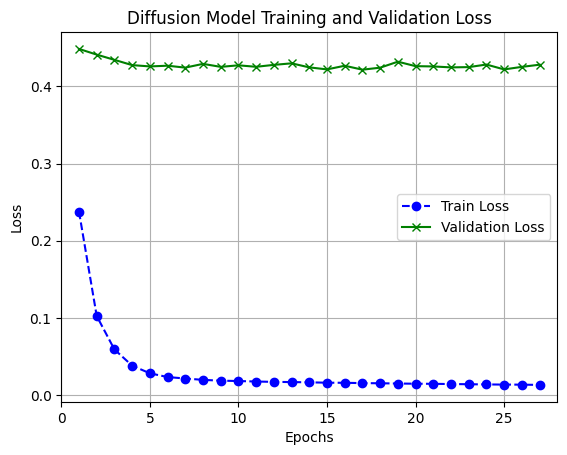

In [ ]:
model_name = 'Diffusion Model'

plot_train_valid(model_name,performance_metrics_DICT)

### Prediction

In [ ]:
def decode_embeddings_to_tokens(embeddings, vocab):
    batch_size, embedding_dim, seq_length = embeddings.shape
    vocab_embeddings = torch.stack([torch.tensor(embed) for embed in vocab.values()])
    embeddings_flattened = embeddings.view(batch_size*seq_length, embedding_dim)
    distances = torch.cdist(embeddings_flattened, vocab_embeddings)
    distances = distances.view(batch_size, seq_length, -1)
    closest_token_indices = torch.argmin(distances, dim=-1)
    decoded_tokens = []
    for batch_idx in range(batch_size):
        tokens = [list(vocab.keys())[idx.item()] for idx in closest_token_indices[batch_idx]]
        decoded_tokens.append(tokens)
    return decoded_tokens

def evaluate_diffusion_model(model, test_loader, vocab, schedule, device):
    model.eval()
    total_test_loss = 0.0
    decoded_formulas = []
    actual_formulas = []

    with torch.no_grad():
        for token_embeddings, noisy_token_embeddings, x, y, t, mask, skeleton_list in test_loader:
            token_embeddings, noisy_token_embeddings, x, y, mask = token_embeddings.to(device), noisy_token_embeddings.to(device), x.to(device), y.to(device), mask.to(device)
            t = random.randint(0, model.num_timesteps - 1)
            pred_embeddings = model.reverse_diffusion(noisy_token_embeddings, schedule)
            loss = denoising_loss(pred_embeddings, noisy_token_embeddings)
            total_test_loss += loss.item()
            decoded_tokens_list = decode_embeddings_to_tokens(pred_embeddings, vocab)
            predicted_formula = ["".join(decoded_tokens).replace('<PAD>', '').replace('+', ' + ') for decoded_tokens in decoded_tokens_list]
            decoded_formulas.append(predicted_formula)
            actual_formula = list(skeleton_list)
            actual_formulas.append(actual_formula)
    avg_test_loss = total_test_loss/len(test_loader)
    return avg_test_loss, decoded_formulas, actual_formulas

dataset = load_dataset('Data/preprocessed_data_with_embeddings.json')
vocab = load_JSON("Data/vocab_embeddings.json")

MAX_LENGTH = determine_max_seq_len(dataset)

schedule = CosineNoiseSchedule(timesteps=1000,device=setup_device())

train_size = int(0.7*len(dataset))
val_size = int(0.15*len(dataset))
test_size = len(dataset) - train_size - val_size 

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset_SR = SymbolicRegressionDataset(train_dataset, vocab, MAX_LENGTH, schedule)
val_dataset_SR = SymbolicRegressionDataset(val_dataset, vocab, MAX_LENGTH, schedule)
test_dataset_SR = SymbolicRegressionDataset(test_dataset, vocab, MAX_LENGTH, schedule)

train_loader = DataLoader(train_dataset_SR, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset_SR, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset_SR, batch_size=16, shuffle=True)

num_heads = 4
embedding_dim = 100
hidden_dim = embedding_dim

if embedding_dim % num_heads != 0:
    raise ValueError(f"embedding_dim ({embedding_dim}) must be divisible by num_heads ({num_heads}).")

model = DiffusionModel(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=4,
    num_heads=4,
    num_timesteps=1000,
    pretrained_embeddings=vocab
)

model, device = load_model(model, "Data/best_diffusion_model_method1.pt")
test_loss, decoded_formulas, actual_formulas = evaluate_diffusion_model(model, test_loader, vocab, schedule, device)

print(f"Test Loss: {test_loss}")

for predicted, actual in zip(decoded_formulas[:5], actual_formulas[:5]):
    print(f"Predicted Formula: {predicted}")
    print(f"Actual Formula: {actual}")
    print("-"*50)

c:\Users\matth\OneDrive - University of Waterloo\Documents\Python Files\Environments\STAT940_Final_Project_VENV\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\matth\AppData\Local\Temp\ipykernel_3308\1325211605.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via thi

Test Loss: 0.9628666043281555
Predicted Formula: ['Cx3x4 + x3tanhCx0x4cos(x2*', ' + ^tanhx3x4x4x3CC)tanhexp', 'x2tanhcosx2Csinexpx4x3tanh + tanhx3x2cosx4', 'x4x2sin +  + ^x3x2sinx4expx0 + C)x1', 'C)x1x1x3)C(x2(cosx4', '^*cosx3tanhx3expx1x4x4cosx3x4', 'x1expx3 + x2expexpx4sincosx1', 'sinx4x3^^tanhx2expx1)', 'cosx1*(expx2x0x3x2 + expx0', 'x3tanhx1exp) + x4Cx4Cx1', ')x0*x3^ + *x3Cx3x1x3x3', '*x2expsinCx4x4 + exptanhx4x3', 'expcossinx1x3x2C**coscosC', '^cos^expx3x4x0sinx1x4x0C', 'x2x0x0expsinsintanhC']
Actual Formula: ['cos(tanh(exp(x2)))', 'C*tanh(x0 + C)', 'C*tanh(x0 + C)', 'C*x0**3 + C*x0*x1 + C*x1**2', 'C*tanh(x0 + C)', 'sin(x0) + C*cos(x1)', 'cos(C*exp(x4))**3', 'x2*tanh(sin(tanh(x3)) + C)', 'C*sin(x2**24)', 'sin(cos(sin(tanh(x3**2)))) + C', 'C*x0**2 + C*x1', 'C*x0**3 + C*x0*x1 + C*x1**2', 'tanh(sin(cos(sin(C*x2*x4))))', 'C*tanh(x0 + C)', 'x0 + cos(cos(exp(x1)))']
--------------------------------------------------


# Alternate Attempt With Cross Attention

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import random
import numpy as np
import json
import math
from torch.nn import functional as F
from dataclasses import dataclass
import pdb

seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

def determine_max_seq_len(data, max_length='max_length'):
    if max_length == 'max_length':
        MAX_LENGTH = max(len(dp["tokens"]) for dp in data)
    else:
        MAX_LENGTH = max_length
    return MAX_LENGTH

def setup_device():
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    return model

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()
    device = setup_device()
    model.to(device)
    return model, device

def load_dataset(filepath):
    with open(filepath, 'r') as file:
        dataset = [json.loads(line) for line in file]
    return dataset

def load_dataset_torch(filepath):
    loaded_data = torch.load(filepath)
    formula_embeddings = loaded_data['formula_embeddings']
    dataset_embeddings = loaded_data['dataset_embeddings']
    return formula_embeddings,dataset_embeddings

def save_JSON(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f)
    return

def load_JSON(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

@dataclass
class tNetConfig:
    num_vars: int
    embedding_size: int

class tNet(nn.Module):
    def __init__(self, config: tNetConfig):
        super(tNet, self).__init__()

        self.config = config
        self.num_vars = config.num_vars
        self.n_embd = config.embedding_size

        self.activation_func = F.relu

        self.conv1 = nn.Conv1d(self.num_vars, self.n_embd, 1)
        self.conv2 = nn.Conv1d(self.n_embd, 2*self.n_embd, 1)
        self.conv3 = nn.Conv1d(2*self.n_embd, 4*self.n_embd, 1)

        self.fc1 = nn.Linear(4*self.n_embd, 2*self.n_embd)
        self.fc2 = nn.Linear(2*self.n_embd, self.n_embd)

        self.input_batch_norm = nn.GroupNorm(1, self.num_vars)
        
        self.bn1 = nn.GroupNorm(1, self.n_embd)
        self.bn2 = nn.GroupNorm(1, 2*self.n_embd)
        self.bn3 = nn.GroupNorm(1, 4*self.n_embd)
        self.bn4 = nn.GroupNorm(1, 2*self.n_embd)
        self.bn5 = nn.GroupNorm(1, self.n_embd)

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
        
        x = self.input_batch_norm(x)
        x = self.activation_func(self.bn1(self.conv1(x)))
        x = self.activation_func(self.bn2(self.conv2(x)))
        x = self.activation_func(self.bn3(self.conv3(x)))

        x, _ = torch.max(x, dim=2)
        assert x.size(1) == 4*self.n_embd

        x = self.activation_func(self.bn4(self.fc1(x)))
        x = self.activation_func(self.bn5(self.fc2(x)))
        return x

class CosineNoiseSchedule:
    def __init__(self, timesteps=1000, epsilon=1e-6, device=None):
        self.timesteps = timesteps
        self.epsilon = epsilon
        self.device = device
        
        self.alphas = torch.cos(torch.linspace(0, math.pi/2, timesteps, device=device))**2
        self.betas = 1.0 - self.alphas
        self.alpha_bar = torch.maximum(torch.cumprod(self.alphas, dim=0), torch.tensor(self.epsilon, device=self.alphas.device))

    def get_alpha(self, t):
        return self.alphas[t]

    def get_beta(self, t):
        return self.betas[t]

    def get_variance(self, t):
        return self.get_beta(t) * (1 - self.get_alpha(t))

    def get_alpha_bar(self, t):
        return self.alpha_bar[t]

class SymbolicRegressionDataset(Dataset):
    def __init__(self, preprocessed_data, vocab, max_seq_len, noise_schedule):
        self.preprocessed_data = preprocessed_data
        self.vocab = vocab
        self.max_seq_len = max_seq_len
        self.noise_schedule = noise_schedule
    
    def add_noise(self, embeddings, t):
        alpha_t = self.noise_schedule.get_alpha(t)
        beta_t = self.noise_schedule.get_beta(t)
        noise = torch.randn_like(embeddings)*torch.sqrt(beta_t)
        noisy_embeddings = torch.sqrt(alpha_t)*embeddings + noise
        return noisy_embeddings

    def __getitem__(self, idx):
        data_point = self.preprocessed_data[idx]
        formula_emb = torch.tensor(data_point['formula_embedding'], dtype=torch.float32)
        dataset_emb =  torch.tensor(data_point['dataset_embedding'], dtype=torch.float32)
        skeleton = data_point['skeleton']

        t = random.randint(0, self.noise_schedule.timesteps - 1)
        noisy_formula_emb = self.add_noise(formula_emb, t)
        return formula_emb, noisy_formula_emb, dataset_emb, t, skeleton

    def __len__(self):
        return len(self.preprocessed_data)

class DiffusionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, num_timesteps, max_seq_len=5000, pretrained_embeddings=None):
        super(DiffusionModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_timesteps = num_timesteps
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.projection = nn.Linear(embedding_dim, hidden_dim) if embedding_dim != hidden_dim else nn.Identity()
        self.layer_norm = nn.LayerNorm(hidden_dim, eps=1e-6)

        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            batch_first=False
        )
        
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim, 
            num_heads=num_heads, 
            batch_first=True
        )

        self.fc_out = nn.Linear(hidden_dim, embedding_dim)
        
    def forward(self, embeddings):
        batch_size, embedding_dim = embeddings.shape
        embeddings = self.projection(embeddings)
        embeddings = self.layer_norm(embeddings)
        embeddings = embeddings.unsqueeze(0) 
        embeddings = self.transformer(embeddings, embeddings)
        embeddings = embeddings.squeeze(0)
        logits = self.fc_out(embeddings)
        return logits

    def reverse_diffusion(self, noisy_formula_embeddings, dataset_embeddings, schedule):
        device = noisy_formula_embeddings.device
        batch_size, embedding_dim = noisy_formula_embeddings.size()
        x_t = noisy_formula_embeddings
        
        tnet = tNet(tNetConfig(num_vars=batch_size,embedding_size=embedding_dim))
        
        dataset_embeddings = dataset_embeddings.unsqueeze(1)
        
        for t in reversed(range(self.num_timesteps)):
            query = x_t.unsqueeze(1)  # [B, 1, D]
            conditioned_embedding, _ = self.cross_attention(
                query=query,
                key=dataset_embeddings,
                value=dataset_embeddings
            )
            x_t = conditioned_embedding.squeeze(1) 
            
            predicted_noise = tnet(x_t) if tnet is not None else self.forward(x_t) 

            alpha_t = schedule.get_alpha(t)
            beta_t = schedule.get_beta(t)
            
            mean_x_prev = (x_t - beta_t * predicted_noise) / torch.sqrt(alpha_t)
            
            if t > 0:
                std_dev = torch.sqrt(beta_t)
                noise = torch.randn_like(x_t, device=device) * std_dev
                x_t = mean_x_prev + noise
            else:
                x_t = mean_x_prev
            
            x_t = torch.clamp(x_t, min=-1.0, max=1.0)
        
        return x_t

def denoising_loss(predicted_embeddings, clean_embeddings):
    return nn.MSELoss()(predicted_embeddings, clean_embeddings)

def train_diffusion_model(model, train_loader, val_loader, num_epochs=10, patience_num_epochs=3):
    device = setup_device()
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    schedule = CosineNoiseSchedule(timesteps=1000, device=device)

    best_val_loss = float('inf')
    num_epochs_without_improvement = 0
    early_stopping = False
    performance_metrics = {"epoch_list": [], "train_loss_list": [], "val_loss_list": []}

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for formula_emb, noisy_formula_emb, dataset_emb, t, skeleton in train_loader:
            formula_emb, noisy_formula_emb, dataset_emb = formula_emb.to(device), noisy_formula_emb.to(device), dataset_emb.to(device)

            optimizer.zero_grad()

            predicted_emb = model(noisy_formula_emb)

            loss = denoising_loss(predicted_emb, formula_emb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        train_loss = total_loss/len(train_loader)
        performance_metrics['train_loss_list'].append(train_loss)

        model.eval()
        val_loss = 0.0
        total_correct = 0
        num_samples = 0

        with torch.no_grad():
            for formula_emb, noisy_formula_emb, dataset_emb, t, skeleton in val_loader:
                formula_emb, noisy_formula_emb, dataset_emb = formula_emb.to(device), noisy_formula_emb.to(device), dataset_emb.to(device)
                predicted_emb = model.reverse_diffusion(noisy_formula_emb, dataset_emb, schedule)
                loss = denoising_loss(predicted_emb, formula_emb)
                val_loss += loss.item()

                num_samples += formula_emb.size(0)

        val_loss = val_loss/len(val_loader)
        performance_metrics['val_loss_list'].append(val_loss)
        performance_metrics['epoch_list'].append(epoch + 1)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, "best_diffusion_model_method2.pt")
            num_epochs_without_improvement = 0
        else:
            num_epochs_without_improvement += 1

        if num_epochs_without_improvement >= patience_num_epochs:
            print(f"Training stopped early at epoch {epoch + 1}. Best validation loss: {best_val_loss}")
            early_stopping = True
            break

    if not early_stopping:
        save_model(model, "best_diffusion_model_method2.pt")

    return model, performance_metrics

dataset = load_dataset('Data/preprocessed_data_with_embeddings.json')
vocab = load_JSON("Data/vocab_embeddings.json") 

MAX_LENGTH = determine_max_seq_len(dataset)

schedule = CosineNoiseSchedule(timesteps=1000,device=setup_device())

train_size = int(0.7*len(dataset))
val_size = int(0.15*len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset_SR = SymbolicRegressionDataset(train_dataset, vocab, MAX_LENGTH, schedule)
val_dataset_SR = SymbolicRegressionDataset(val_dataset, vocab, MAX_LENGTH, schedule)
test_dataset_SR = SymbolicRegressionDataset(test_dataset, vocab, MAX_LENGTH, schedule)

train_loader = DataLoader(train_dataset_SR, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset_SR, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset_SR, batch_size=16, shuffle=True)

num_heads = 4 
embedding_dim = 128 
hidden_dim = embedding_dim

if embedding_dim % num_heads != 0:
    raise ValueError(f"embedding_dim ({embedding_dim}) must be divisible by num_heads ({num_heads}).")

model = DiffusionModel(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=4,
    num_heads=4,
    num_timesteps=1000,
    pretrained_embeddings=vocab,
)

model,performance_metrics_DICT = train_diffusion_model(model,train_loader,val_loader,num_epochs=100,patience_num_epochs=100)

Epoch 1/100, Train Loss: 0.7206235289573669, Val Loss: 0.6199209690093994
Epoch 2/100, Train Loss: 0.46560250520706176, Val Loss: 0.6199209690093994
Epoch 3/100, Train Loss: 0.3378569185733795, Val Loss: 0.6199209690093994
Epoch 4/100, Train Loss: 0.2589802235364914, Val Loss: 0.6199209690093994
Epoch 5/100, Train Loss: 0.214978489279747, Val Loss: 0.6199209690093994
Epoch 6/100, Train Loss: 0.1942541182041168, Val Loss: 0.6199209690093994
Epoch 7/100, Train Loss: 0.17953898012638092, Val Loss: 0.6199209690093994
Epoch 8/100, Train Loss: 0.17081521451473236, Val Loss: 0.6199209690093994
Epoch 9/100, Train Loss: 0.16131505072116853, Val Loss: 0.6199209690093994
Epoch 10/100, Train Loss: 0.1597515672445297, Val Loss: 0.6199209690093994
Epoch 11/100, Train Loss: 0.14926388263702392, Val Loss: 0.6199209690093994
Epoch 12/100, Train Loss: 0.1479350209236145, Val Loss: 0.6199209690093994
Epoch 13/100, Train Loss: 0.14628997445106506, Val Loss: 0.6199209690093994
Epoch 14/100, Train Loss: 0.1

### Plotting Results

In [ ]:
import matplotlib.pyplot as plt

def plot_train_valid(model_name,performance_metrics_DICT):
    plt.figure();
    plt.plot(performance_metrics_DICT['epoch_list'], performance_metrics_DICT['train_loss_list'], label=f'Train Loss', color='blue', linestyle='--', marker='o');
    plt.plot(performance_metrics_DICT['epoch_list'], performance_metrics_DICT['val_loss_list'], label=f'Validation Loss', color='green', linestyle='-', marker='x');
    plt.title(f'{model_name} Training and Validation Loss');
    plt.xlabel('Epochs');
    plt.ylabel('Loss');
    plt.legend();
    plt.grid();
    plt.xlim(0,max(performance_metrics_DICT['epoch_list'])+1);
    return

In [ ]:
model_name = 'Diffusion Model'

plot_train_valid(model_name,performance_metrics_DICT)

### Prediction

In [ ]:
def decode_embeddings_to_tokens(embeddings, vocab):
    batch_size, embedding_dim, seq_length = embeddings.shape
    vocab_embeddings = torch.stack([torch.tensor(embed) for embed in vocab.values()])

    embeddings_flattened = embeddings.view(batch_size*seq_length, embedding_dim)
    
    distances = torch.cdist(embeddings_flattened, vocab_embeddings)  # Shape: [batch_size * seq_length, num_symbols]

    distances = distances.view(batch_size, seq_length, -1)
    
    # Find the index of the closest token for each position in the sequence
    closest_token_indices = torch.argmin(distances, dim=-1)  # Shape: [batch_size, seq_length]
    
    # Convert indices to tokens
    decoded_tokens = []
    for batch_idx in range(batch_size):
        tokens = [list(vocab.keys())[idx.item()] for idx in closest_token_indices[batch_idx]]
        decoded_tokens.append(tokens)

    return decoded_tokens

def evaluate_diffusion_model(model, test_loader, vocab, schedule, device):
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    decoded_formulas = []
    actual_formulas = []

    with torch.no_grad():
        for token_embeddings, noisy_token_embeddings, x, y, t, mask, skeleton_list in test_loader:
            token_embeddings, noisy_token_embeddings, x, y, mask = token_embeddings.to(device), noisy_token_embeddings.to(device), x.to(device), y.to(device), mask.to(device)
            # Get the predicted denoised embeddings
            t = random.randint(0, model.num_timesteps - 1)  # Random timestep for diffusion
            pred_embeddings = model.reverse_diffusion(noisy_token_embeddings, schedule)

            # Calculate the loss (MSE between predicted and target embeddings)
            loss = denoising_loss(pred_embeddings, noisy_token_embeddings)
            total_test_loss += loss.item()

            # Now, we need to decode the denoised embeddings back to tokens
            decoded_tokens_list = decode_embeddings_to_tokens(pred_embeddings, vocab)

            # Convert the decoded tokens to a formula string
            predicted_formula = ["".join(decoded_tokens).replace('<PAD>', '').replace('+', ' + ') for decoded_tokens in decoded_tokens_list]
            decoded_formulas.append(predicted_formula)

            # Assuming target embeddings have a corresponding ground truth formula (you can adjust this part)
            actual_formula = list(skeleton_list)
            actual_formulas.append(actual_formula)

    # Calculate average test loss
    avg_test_loss = total_test_loss/len(test_loader)
    return avg_test_loss, decoded_formulas, actual_formulas

# Example of loading and preparing the dataset
dataset = load_dataset('Data/preprocessed_data_with_embeddings.json')
vocab = load_JSON("Data/vocab_embeddings.json")  # Vocabulary is a dictionary of continuous embeddings

MAX_LENGTH = determine_max_seq_len(dataset)  # Determine the max length dynamically

schedule = CosineNoiseSchedule(timesteps=1000,device=setup_device())

# First, perform the split on the raw dataset
train_size = int(0.7*len(dataset))  # 70% for training
val_size = int(0.15*len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

# Perform random split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset_SR = SymbolicRegressionDataset(train_dataset, vocab, MAX_LENGTH, schedule)
val_dataset_SR = SymbolicRegressionDataset(val_dataset, vocab, MAX_LENGTH, schedule)
test_dataset_SR = SymbolicRegressionDataset(test_dataset, vocab, MAX_LENGTH, schedule)

# Create DataLoader objects for each subset
train_loader = DataLoader(train_dataset_SR, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset_SR, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset_SR, batch_size=16, shuffle=True)

# Initialize the model
num_heads = 4  # Number of attention heads, ensure this is a divisor of embedding_dim
embedding_dim = 100  # The embedding dimension is 100 as per your problem
hidden_dim = embedding_dim  # Hidden dimension stays the same for simplicity

# Ensure embedding_dim is divisible by num_heads
if embedding_dim % num_heads != 0:
    raise ValueError(f"embedding_dim ({embedding_dim}) must be divisible by num_heads ({num_heads}).")

model = DiffusionModel(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=4,
    num_heads=4,
    num_timesteps=1000,
    pretrained_embeddings=vocab
)

# Example: Evaluate the model on the test set
model, device = load_model(model, "Data/best_diffusion_model_method2.pt")
test_loss, decoded_formulas, actual_formulas = evaluate_diffusion_model(model, test_loader, vocab, schedule, device)

# Print out the average test loss
print(f"Test Loss: {test_loss}")

# Print out the first few decoded formulas and their corresponding actual formulas
for predicted, actual in zip(decoded_formulas[:5], actual_formulas[:5]):
    print(f"Predicted Formula: {predicted}")
    print(f"Actual Formula: {actual}")
    print("-"*50)

In [ ]:
actual_formulas = actual_formulas[0]
decoded_formulas = decoded_formulas[0]

# Performance Metrics

In [ ]:
import re 

def tokenize_skeleton(skeleton_str):
    skeleton_str = skeleton_str.replace("**", "^")
    pattern = r'[a-zA-Z_][a-zA-Z0-9_]*|[+\-*/^(),.]|C|sin|cos|log|exp|sqrt'
    tokens = re.findall(pattern, skeleton_str)
    return tokens

### BLEU Score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu(actual_formulas,decoded_formulas):
    total_bleu = 0
    smoothing = SmoothingFunction().method1

    for actual_formula, reconstructed_formula in zip(actual_formulas,decoded_formulas):
        reference = [tokenize_skeleton(actual_formula)]
        candidate = tokenize_skeleton(reconstructed_formula)

        bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothing)
        total_bleu += bleu_score

    average_bleu = total_bleu / len(actual_formulas) if actual_formulas else 0
    return average_bleu

In [ ]:
average_bleu = calculate_bleu(actual_formulas,decoded_formulas)

In [ ]:
average_bleu

0.022679879435846356

### Token similarity

In [ ]:
def calculate_token_accuracy(actual_formulas,decoded_formulas):
    total_tokens = 0
    correct_tokens = 0

    for actual_formula, reconstructed_formula in zip(actual_formulas,decoded_formulas):
        actual_tokens = tokenize_skeleton(actual_formula)
        reconstructed_tokens = tokenize_skeleton(reconstructed_formula)

        total_tokens += len(actual_tokens)
        correct_tokens += sum(1 for a, r in zip(actual_tokens, reconstructed_tokens) if a == r)

    token_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
    return token_accuracy

In [ ]:
token_accuracy = calculate_token_accuracy(actual_formulas,decoded_formulas)

In [ ]:
token_accuracy

0.029940119760479042

### Edit Distance

In [ ]:
from nltk.metrics import edit_distance

def calculate_edit_distance(actual_formulas,decoded_formulas):
    total_distance = 0

    for actual_formula, reconstructed_formula in zip(actual_formulas,decoded_formulas):
        actual_tokens = tokenize_skeleton(actual_formula)
        reconstructed_tokens = tokenize_skeleton(reconstructed_formula)
        total_distance += edit_distance(actual_tokens, reconstructed_tokens)

    average_distance = total_distance / len(actual_tokens) if actual_tokens else 0
    return average_distance

In [ ]:
edit_distance = calculate_edit_distance(actual_formulas,decoded_formulas)

In [ ]:
edit_distance

12.416666666666666